# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [81]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
# #     When running on the CuDNN backend, two further options must be set
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
# #     Set a fixed value for the hash seed
#     os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [9]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Your Code from here...

In [11]:
from torch.utils.data import DataLoader
# loading the data set
train_loader = DataLoader(train, batch_size=len(train), shuffle=True, num_workers=0)
X,y = next(iter(train_loader))

from sklearn.model_selection import train_test_split
# Split into X_train, y_train, X_test, y_test
# Using stratified splitting from sklearn library( We could have used StratifiedShuffleSplit, 
# but that is essentially the same thing)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, train_size=0.9)


In [12]:
print(y.unique(return_counts=True))
print(y_train.unique(return_counts = True))
print(y_val.unique(return_counts = True))
# Perfectly uniform distributed!!!

print(X_train[0].shape)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))
torch.Size([3, 32, 32])


The **UnNormalize** class will be used to apply the inverse normalization to a tensor. The `__init__` method initializes the object with the given mean and standard deviation. The `__call__` method takes in a tensor and applies the inverse of normalization to it. The normalization is applied to each element of the tensor separately, by first multiplying the element by the standard deviation and then adding the mean.


In [23]:
class UnNormalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    for i in range(tensor.shape[0]):
        t = tensor[i]
        m = self.mean
        s = self.std
        t.mul_(s).add_(m)
    return tensor

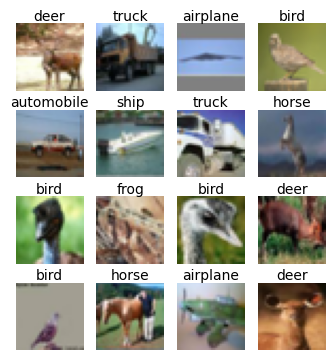

In [220]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
set_seed()
indices = np.random.randint(0, len(X_train), size=16)
images = X_train[indices]

images = images * 0.5 + 0.5
images = images.permute(0, 2, 3, 1) #Rearranging dimensions
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [classes[i] for i in y_train[indices].tolist()]

# create a figure with a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(4,4.3))

# display each image and its corresponding label
for i, (image, label) in enumerate(zip(images, labels)):
    ax = axs[i // 4, i % 4]
    ax.imshow(np.squeeze(image), cmap="gray")
    ax.set_title(label, fontsize=10, pad=0)
    ax.axis('off')
    
plt.show()

## Creating a Dataset Class


In [57]:
# Dataset Class to aid wrapping into a DataLoader
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [210]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)  # Adding batch norm layer (Increased performance tremendously)
        self.pool1 = nn.MaxPool2d(2, 2) # Max Pool layer with kernel_size = stride = 2. Therefore, halves the height and width of input image
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)  # Add batch norm layer
        self.pool2 = nn.MaxPool2d(2,2) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x)))) 
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5) # Reshaping
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [207]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    
    # setting up the plot
    plt.figure()
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.ion()   # turn on interactive mode
    
    i = 0
    running_loss = 0 #Accumulates loss over display_step number of minibatches
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad() # To avoid accumulation of gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() # Backpropagation
        i += 1
        running_loss += loss.item()
        if(display_step): 
            if(i%display_step == 0):  
                print(f"Training Loss at {i} mini-batches: {running_loss/display_step}")
                acc = accuracy(predict(model, X_val.numpy()),y_val.numpy())
                print(f"Accuracy Score on Validation Data at {i} mini-batches: {acc} ")
                running_loss = 0   
                plt.scatter(i, acc)
    plt.ioff()
    plt.show()

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [65]:
# Predicts the class based on the whichever class has the highest match or activation value
def predict(model, X_test):
    preds = model(torch.from_numpy(X_test)).detach().numpy()
    preds[preds<0] = 0
    return preds.argmax(axis=1)

In [69]:
from sklearn.metrics import accuracy_score

def accuracy(pred, labels):
    return accuracy_score(labels, pred)

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [211]:
import torch.optim as optim

set_seed()
model = CNN() # Initialising a model
optimiser = optim.SGD(model.parameters(), lr=0.005, momentum = 0.8) # Stochastic Gradient Descent Optimiser
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss criterion

dataset = MyDataset(X_train, y_train)

### Certain Observations: 
<ul>
    <li>Changing learning rate from 0.001 to 0.005 lead to faster learning</li>
    <li>Reducing momentum from 0.9 to 0.8 also helped in initial faster learning</li>  
    <li>We gradually increase size of batches so as to save time </li>
</ul>

Training Loss at 450 mini-batches: 2.0337319633695814
Accuracy Score on Validation Data at 450 mini-batches: 0.313 
Training Loss at 900 mini-batches: 1.7316932720608182
Accuracy Score on Validation Data at 900 mini-batches: 0.405 
Training Loss at 1350 mini-batches: 1.6296784155898625
Accuracy Score on Validation Data at 1350 mini-batches: 0.4276 
Training Loss at 1800 mini-batches: 1.5612690671284994
Accuracy Score on Validation Data at 1800 mini-batches: 0.4518 
Training Loss at 2250 mini-batches: 1.5150909268856048
Accuracy Score on Validation Data at 2250 mini-batches: 0.4756 
Training Loss at 2700 mini-batches: 1.507423070801629
Accuracy Score on Validation Data at 2700 mini-batches: 0.4806 
Training Loss at 3150 mini-batches: 1.4461067179838816
Accuracy Score on Validation Data at 3150 mini-batches: 0.4982 
Training Loss at 3600 mini-batches: 1.4270966243743897
Accuracy Score on Validation Data at 3600 mini-batches: 0.4828 
Training Loss at 4050 mini-batches: 1.4134115330378214


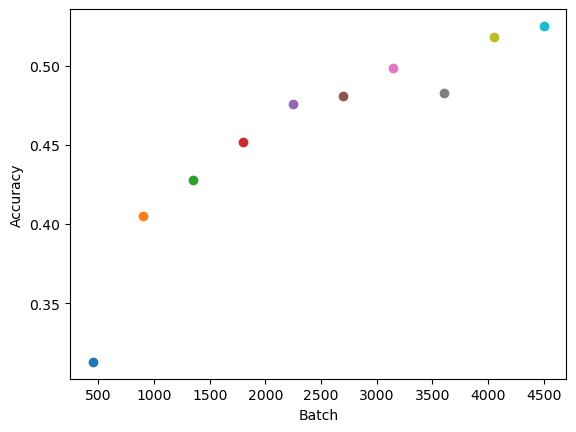

Training Loss at 450 mini-batches: 1.3376368774970373
Accuracy Score on Validation Data at 450 mini-batches: 0.5238 
Training Loss at 900 mini-batches: 1.2983966897593604
Accuracy Score on Validation Data at 900 mini-batches: 0.549 
Training Loss at 1350 mini-batches: 1.2548177856869167
Accuracy Score on Validation Data at 1350 mini-batches: 0.5392 
Training Loss at 1800 mini-batches: 1.2446202435096105
Accuracy Score on Validation Data at 1800 mini-batches: 0.5468 
Training Loss at 2250 mini-batches: 1.2597150925795237
Accuracy Score on Validation Data at 2250 mini-batches: 0.5492 
Training Loss at 2700 mini-batches: 1.1947744768857955
Accuracy Score on Validation Data at 2700 mini-batches: 0.5684 
Training Loss at 3150 mini-batches: 1.2141512202554279
Accuracy Score on Validation Data at 3150 mini-batches: 0.5758 
Training Loss at 3600 mini-batches: 1.1808112396796544
Accuracy Score on Validation Data at 3600 mini-batches: 0.5718 


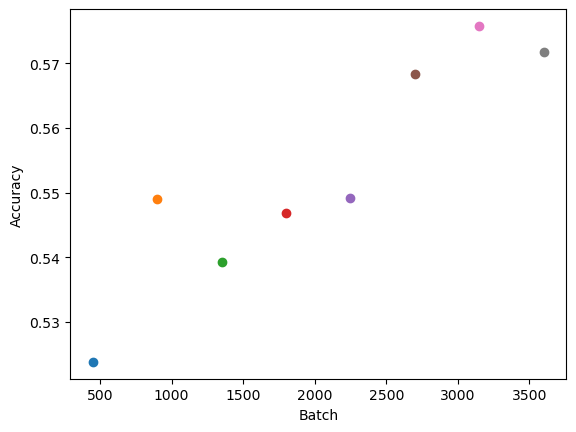

Training Loss at 450 mini-batches: 1.1758939768208398
Accuracy Score on Validation Data at 450 mini-batches: 0.583 
Training Loss at 900 mini-batches: 1.152428312169181
Accuracy Score on Validation Data at 900 mini-batches: 0.5736 
Training Loss at 1350 mini-batches: 1.1017828996313943
Accuracy Score on Validation Data at 1350 mini-batches: 0.5832 
Training Loss at 1800 mini-batches: 1.1199081705676184
Accuracy Score on Validation Data at 1800 mini-batches: 0.5892 
Training Loss at 2250 mini-batches: 1.0922901849614248
Accuracy Score on Validation Data at 2250 mini-batches: 0.582 
Training Loss at 2700 mini-batches: 1.0785857898659177
Accuracy Score on Validation Data at 2700 mini-batches: 0.5934 
Training Loss at 3150 mini-batches: 1.060085368156433
Accuracy Score on Validation Data at 3150 mini-batches: 0.5866 


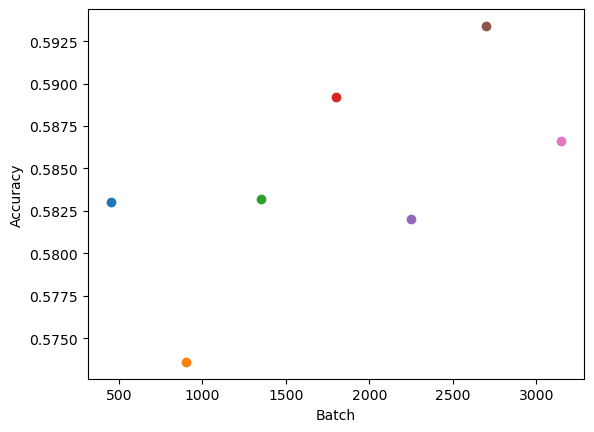

Training Loss at 450 mini-batches: 1.0682166605525547
Accuracy Score on Validation Data at 450 mini-batches: 0.6048 
Training Loss at 900 mini-batches: 1.0505888224310345
Accuracy Score on Validation Data at 900 mini-batches: 0.6186 
Training Loss at 1350 mini-batches: 1.0174839995967018
Accuracy Score on Validation Data at 1350 mini-batches: 0.6092 
Training Loss at 1800 mini-batches: 1.02445885181427
Accuracy Score on Validation Data at 1800 mini-batches: 0.6008 
Training Loss at 2250 mini-batches: 0.9847282503710852
Accuracy Score on Validation Data at 2250 mini-batches: 0.6218 
Training Loss at 2700 mini-batches: 0.9742278524239858
Accuracy Score on Validation Data at 2700 mini-batches: 0.6188 


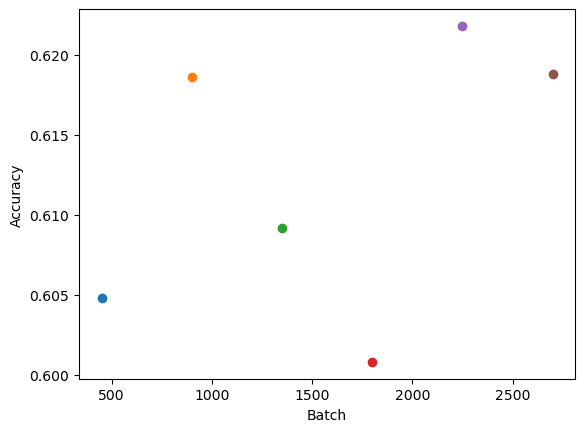

Training Loss at 450 mini-batches: 0.9882788504494561
Accuracy Score on Validation Data at 450 mini-batches: 0.618 
Training Loss at 900 mini-batches: 0.9481628545125326
Accuracy Score on Validation Data at 900 mini-batches: 0.619 
Training Loss at 1350 mini-batches: 0.9590337214205
Accuracy Score on Validation Data at 1350 mini-batches: 0.621 
Training Loss at 1800 mini-batches: 0.9195925871531169
Accuracy Score on Validation Data at 1800 mini-batches: 0.6296 
Training Loss at 2250 mini-batches: 0.9221037705077065
Accuracy Score on Validation Data at 2250 mini-batches: 0.6316 


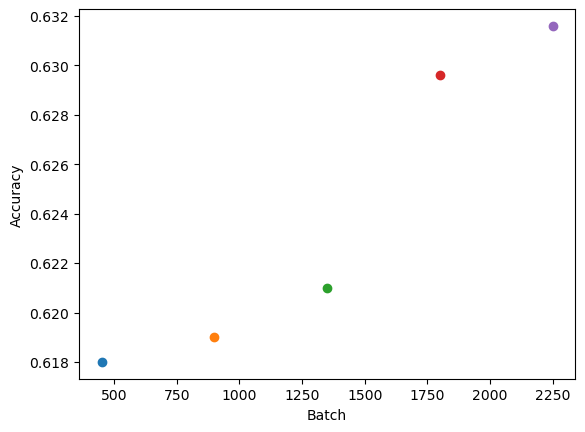

In [212]:
for i in range(5):
    train(model, optimiser, criterion, DataLoader(dataset, batch_size = 10+2*i, shuffle = False), (4500/10))

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [213]:
predictions = predict(model, X_val.numpy())
accuracy(predictions, y_val.numpy())

0.6308

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

The model must be trained on entire of training set before deploying it as the final model. We observe that not significant change happens after 3 epochs, hence we will perform 3 epochs with batch_size = 10 and one final epoch with batch_size = 25.

Training Loss at 500 mini-batches: 2.015075937986374
Accuracy Score on Validation Data at 500 mini-batches: 0.2966 
Training Loss at 1000 mini-batches: 1.721116568684578
Accuracy Score on Validation Data at 1000 mini-batches: 0.4164 
Training Loss at 1500 mini-batches: 1.6076651359796523
Accuracy Score on Validation Data at 1500 mini-batches: 0.4502 
Training Loss at 2000 mini-batches: 1.5775369170904159
Accuracy Score on Validation Data at 2000 mini-batches: 0.4492 
Training Loss at 2500 mini-batches: 1.4943691403865815
Accuracy Score on Validation Data at 2500 mini-batches: 0.4662 
Training Loss at 3000 mini-batches: 1.4794801224470138
Accuracy Score on Validation Data at 3000 mini-batches: 0.4804 
Training Loss at 3500 mini-batches: 1.4294519535303116
Accuracy Score on Validation Data at 3500 mini-batches: 0.5 
Training Loss at 4000 mini-batches: 1.419017116010189
Accuracy Score on Validation Data at 4000 mini-batches: 0.5124 
Training Loss at 4500 mini-batches: 1.3988170080184936
A

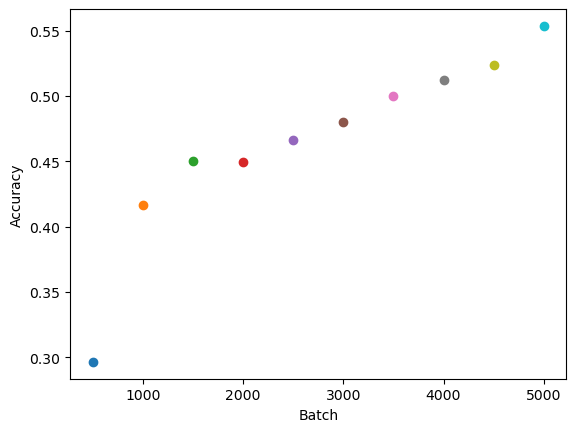

Training Loss at 500 mini-batches: 1.3466797162294388
Accuracy Score on Validation Data at 500 mini-batches: 0.5438 
Training Loss at 1000 mini-batches: 1.3036025627255439
Accuracy Score on Validation Data at 1000 mini-batches: 0.5704 
Training Loss at 1500 mini-batches: 1.2674964089393617
Accuracy Score on Validation Data at 1500 mini-batches: 0.5566 
Training Loss at 2000 mini-batches: 1.2940039319992065
Accuracy Score on Validation Data at 2000 mini-batches: 0.5752 
Training Loss at 2500 mini-batches: 1.2286428444981574
Accuracy Score on Validation Data at 2500 mini-batches: 0.5714 
Training Loss at 3000 mini-batches: 1.240900176882744
Accuracy Score on Validation Data at 3000 mini-batches: 0.5704 
Training Loss at 3500 mini-batches: 1.2058267078399658
Accuracy Score on Validation Data at 3500 mini-batches: 0.5972 
Training Loss at 4000 mini-batches: 1.218773285984993
Accuracy Score on Validation Data at 4000 mini-batches: 0.5956 
Training Loss at 4500 mini-batches: 1.21417020714283

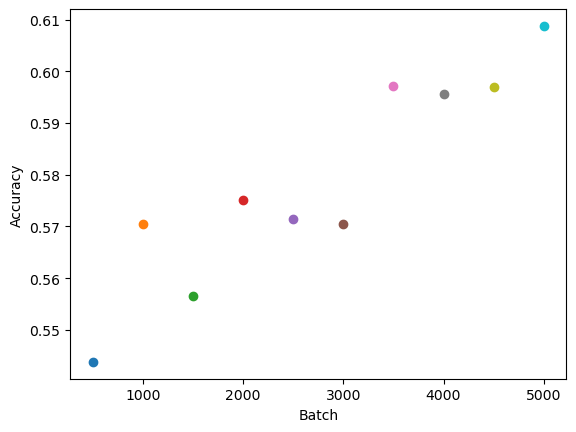

Training Loss at 500 mini-batches: 1.1832470546364784
Accuracy Score on Validation Data at 500 mini-batches: 0.6144 
Training Loss at 1000 mini-batches: 1.1485434732437134
Accuracy Score on Validation Data at 1000 mini-batches: 0.625 
Training Loss at 1500 mini-batches: 1.1104585680365562
Accuracy Score on Validation Data at 1500 mini-batches: 0.62 
Training Loss at 2000 mini-batches: 1.1479591535031795
Accuracy Score on Validation Data at 2000 mini-batches: 0.6328 
Training Loss at 2500 mini-batches: 1.074050153017044
Accuracy Score on Validation Data at 2500 mini-batches: 0.6318 
Training Loss at 3000 mini-batches: 1.1069107901453972
Accuracy Score on Validation Data at 3000 mini-batches: 0.6216 
Training Loss at 3500 mini-batches: 1.0722570892572403
Accuracy Score on Validation Data at 3500 mini-batches: 0.6396 
Training Loss at 4000 mini-batches: 1.0985718159675597
Accuracy Score on Validation Data at 4000 mini-batches: 0.6264 
Training Loss at 4500 mini-batches: 1.107170062482357


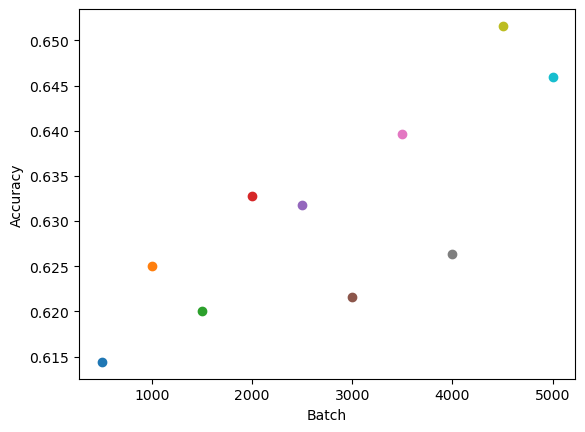

Training Loss at 200 mini-batches: 1.0160910132527352
Accuracy Score on Validation Data at 200 mini-batches: 0.6836 
Training Loss at 400 mini-batches: 0.958563361018896
Accuracy Score on Validation Data at 400 mini-batches: 0.6726 
Training Loss at 600 mini-batches: 0.9241952446103096
Accuracy Score on Validation Data at 600 mini-batches: 0.6832 
Training Loss at 800 mini-batches: 0.9511511793732643
Accuracy Score on Validation Data at 800 mini-batches: 0.692 
Training Loss at 1000 mini-batches: 0.8918492057919503
Accuracy Score on Validation Data at 1000 mini-batches: 0.69 
Training Loss at 1200 mini-batches: 0.917519462108612
Accuracy Score on Validation Data at 1200 mini-batches: 0.68 
Training Loss at 1400 mini-batches: 0.8861549861729145
Accuracy Score on Validation Data at 1400 mini-batches: 0.6916 
Training Loss at 1600 mini-batches: 0.9147071962058544
Accuracy Score on Validation Data at 1600 mini-batches: 0.6956 
Training Loss at 1800 mini-batches: 0.9131369894742966
Accuracy

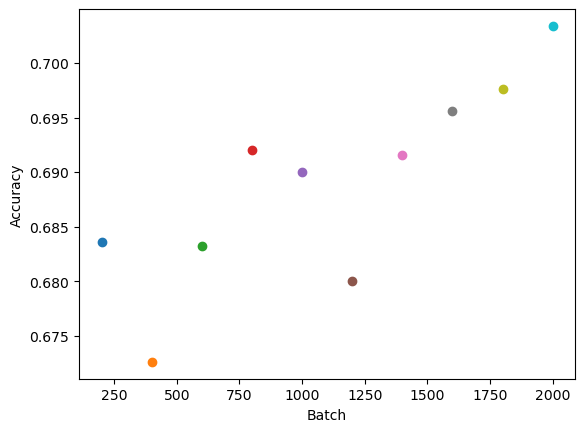

In [265]:
set_seed()
final_model = CNN() # Initialising a model
optimiser = optim.SGD(final_model.parameters(), lr=0.005, momentum = 0.8) # Stochastic Gradient Descent Optimiser
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss criterion

dataset = MyDataset(X,y)

for i in range(3):
    train(final_model, optimiser, criterion, DataLoader(dataset, batch_size = 10, shuffle = False), (5000/10))
train(final_model, optimiser, criterion, DataLoader(dataset, batch_size = 25, shuffle = False), (5000/25))
    

In [266]:
torch.save(final_model, 'ass_3.pt')

Check if it got saved right!

In [267]:
# load the model, use predict function
loaded_model = torch.load('ass_3.pt')
predictions = predict(loaded_model, X_val.numpy())
accuracy(predictions, y_val.numpy())

0.7034

### Predictions on Testing Data

In [268]:
test_loader = DataLoader(test, batch_size=len(test), shuffle=True, num_workers=0)
X_test,y_test = next(iter(test_loader))

In [269]:
y_test.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [270]:
preds_test = predict(loaded_model, X_test.numpy())

In [271]:
accuracy(preds_test, y_test)

0.6511

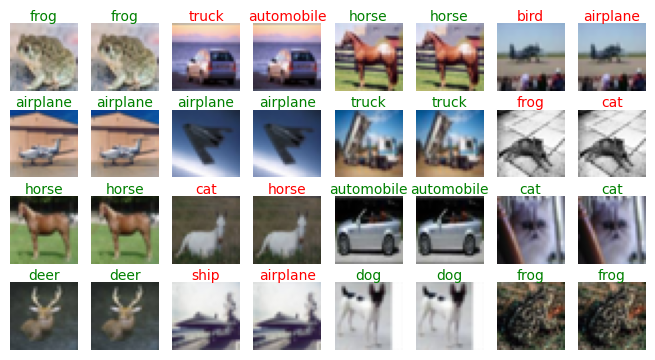

In [274]:
set_seed(786)

indices = np.random.randint(0, len(X_test), size=16)
images = X_test[indices]

images = images * 0.5 + 0.5
images = images.permute(0, 2, 3, 1) 
labels = [classes[i] for i in preds_test[indices].tolist()]
true_labels = [classes[i] for i in y_test[indices]]
# create a figure with a 4x4 grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(8.2,4.3))

i = -1

# display each image and its corresponding label
for (image, label, true_label) in zip(images, labels, true_labels):
    i = i + 1
    ax = axs[i // 8, i % 8]
    ax.imshow(np.squeeze(image), cmap="gray")
    ax.axis('off')
    
    i = i + 1
    ax1 = axs[i // 8, i % 8]
    ax1.imshow(np.squeeze(image), cmap="gray")
    ax1.axis('off')
    
    if (label == true_label):
        ax.set_title(label, fontsize=10, pad=0, color = 'green')
        ax1.set_title(true_label, fontsize=10, pad=0,color='green')
    else:
        ax.set_title(label, fontsize=10, pad=0, color = 'red')
        ax1.set_title(true_label, fontsize=10, pad=0, color = 'red')
plt.show()